# Import the Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_finance import candlestick_ohlc

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble.forest import RandomForestRegressor

from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


/Users/pardeepkumar/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Preprocessing the stock prices

In [2]:
stock_names = ['Apple','Netflix','Google']
# Define empty dataframe to store the stock closing prices
df = pd.DataFrame()
df_high = pd.DataFrame()
df_low = pd.DataFrame()
for stock in stock_names:
    # Read the stock closing prices with date as the index column.
    df[stock] = pd.read_csv(stock+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1]).close
    df_high[stock] = pd.read_csv(stock+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1]).high
    df_low[stock] = pd.read_csv(stock+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1]).low
# Rearange the data in ascending chronological order
df = df.sort_index()
df_high = df_high.sort_index()
df_low = df_low.sort_index()
# Forward fill the missing holiday and weekend stock closing prices
df = df.resample('D').ffill()
df_high = df_high.resample('D').ffill()
df_low = df_low.resample('D').ffill()
# Log-transform the closing price data frame
df_log = np.log(df)
df_high_log = np.log(df_high)
df_low_log = np.log(df_low)
# Display first five five rows of the data frame
df_log.head()

,Apple,Netflix,Google
date,,,
2009-02-23,2.519421,1.625882,5.116364
2009-02-24,2.556677,1.639269,5.161938
2009-02-25,2.566709,1.631767,5.150848
2009-02-26,2.544857,1.631473,5.137707
2009-02-27,2.546206,1.644245,5.140106


# Mean Absolute Percentage Error

In [25]:
def MAPE(y_true,y_pred):
    """  input:
    y_true = True value of variables
    y_pred = predicted values of variable
    output:
    MAPE = mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred) # make sure input is flat   
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Simple Moving Averages

In [4]:
# 5-days Simple Moving Average
SMA5 = df_log.rolling(window=5).mean()
# 10-days Simple Moving Average
SMA10 = df_log.rolling(window=10).mean()

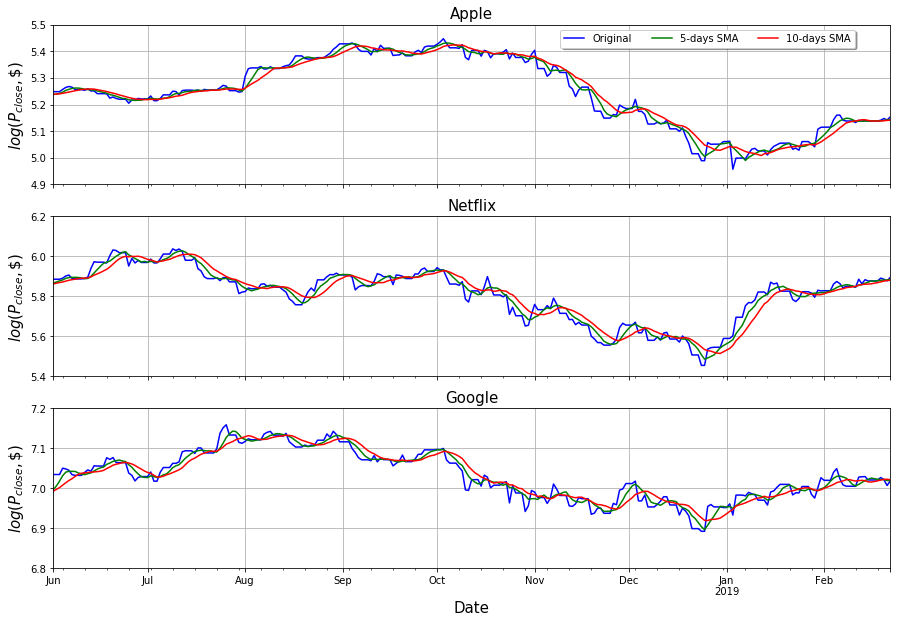

In [5]:
start_date = '2018-06-01'
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):
    df_log.loc[start_date:,stock_names[i]].plot(ax = axs[i], color = 'blue')
    SMA5.loc[start_date:,stock_names[i]].plot(ax = axs[i], color = 'green')
    SMA10.loc[start_date:,stock_names[i]].plot(ax = axs[i], color='red') 
    axs[2].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].legend(['Original','5-days SMA','10-days SMA'], bbox_to_anchor=(0.6, 1.00),fancybox=True, shadow=True, ncol=5)
    axs[i].set_title(stock_names[i], size = '15')
    axs[i].set_xlim([start_date,'2019-02-22'])    
    axs[0].set_ylim([4.9,5.5])
    axs[1].set_ylim([5.4,6.2])
    axs[2].set_ylim([6.8,7.2])   
    axs[i].grid()
plt.subplots_adjust(wspace = 0.04, hspace = 0.2)
plt.show()

# Exponential Moving Average

In [6]:
# 5-days Exponential Moving Average
EMA5 = df_log.ewm(span=5, adjust=False).mean()
# 10-days Exponential Moving Average
EMA10 = df_log.ewm(span=10, adjust=False).mean()

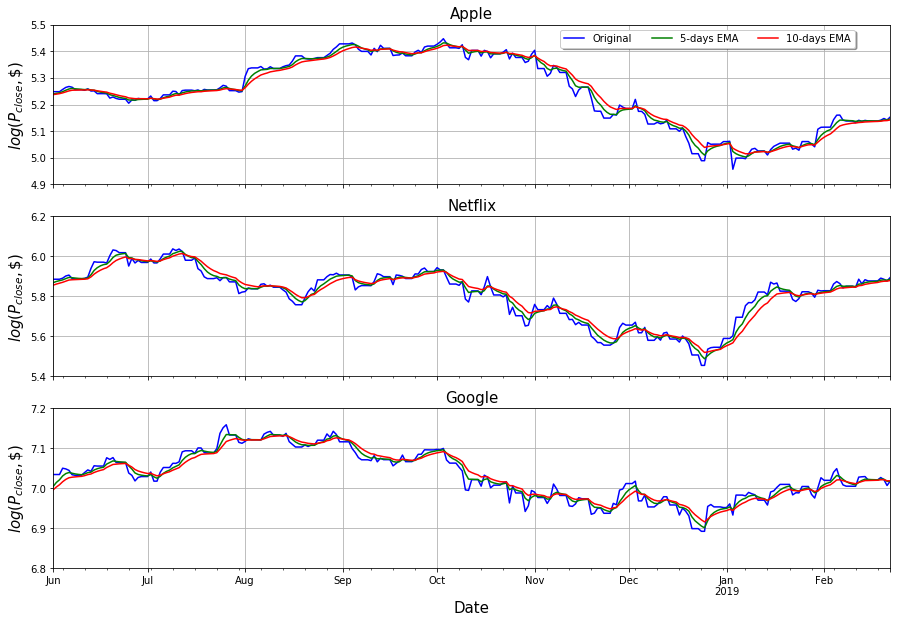

In [7]:
start_date = '2018-06-01'
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):
    df_log.loc[start_date:,stock_names[i]].plot(ax = axs[i], color = 'blue')
    EMA5.loc[start_date:,stock_names[i]].plot(ax = axs[i], color = 'green')
    EMA10.loc[start_date:,stock_names[i]].plot(ax = axs[i], color='red') 
    axs[2].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].legend(['Original','5-days EMA','10-days EMA'], bbox_to_anchor=(0.6, 1.00),fancybox=True, shadow=True, ncol=5)
    axs[i].set_title(stock_names[i], size = '15')
    axs[i].set_xlim([start_date,'2019-02-22'])    
    axs[0].set_ylim([4.9,5.5])
    axs[1].set_ylim([5.4,6.2])
    axs[2].set_ylim([6.8,7.2])   
    axs[i].grid()
plt.subplots_adjust(wspace = 0.04, hspace = 0.2)
plt.show()

# Moving Average Convergence Divergence

In [8]:
# Moving Average Convergence Divergence
nfast = 12
nslow=26
nsignal = 9

ema_fast = df_log.ewm(ignore_na=False, span=nfast,min_periods=0, adjust=True).mean()
ema_fast = df_log.ewm(ignore_na=False, span=nfast,min_periods=0, adjust=True).mean()
ema_slow = df_log.ewm(ignore_na=False, span=nslow,min_periods=0, adjust=True).mean()
macd_line = ema_fast-ema_slow
macd_signal = macd_line.ewm(ignore_na=False, span=nsignal,min_periods=0, adjust=True).mean()

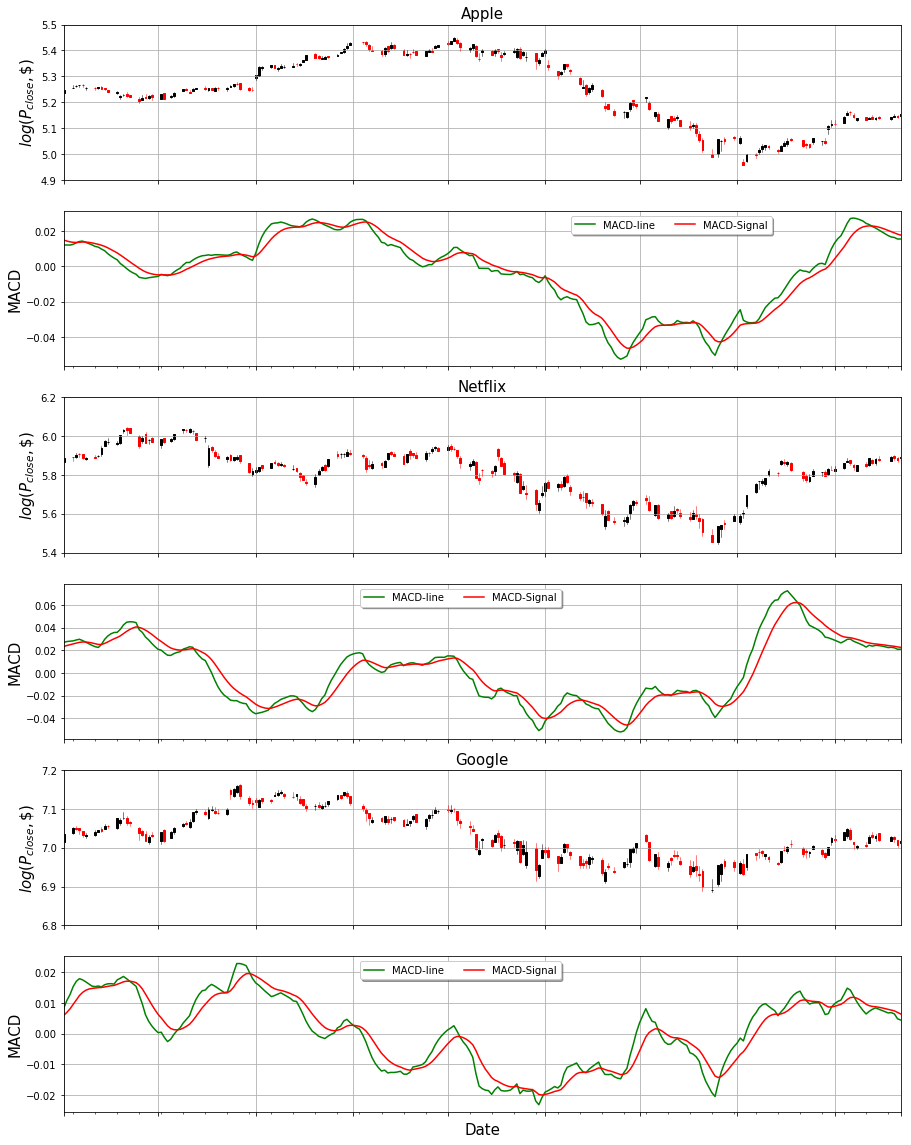

In [9]:
start_date = '2018-06-01'
fig, axs = plt.subplots(6,1, figsize=(15, 20))#, facecolor='w', edgecolor='k')
for i in range(3):
    stock = pd.read_csv(stock_names[i]+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1],infer_datetime_format=True)
    stock = np.log(stock)
    candlestick_ohlc(axs[2*i], zip(mdates.date2num(stock.index.to_pydatetime()),
                             stock['open'], stock['high'],
                             stock['low'], stock['close']),
                     width=0.6)

    axs[2*i].xaxis_date()
    axs[2*i].set_xlim([start_date,'2019-02-22']) 
    axs[2*i].grid()
    axs[2*i].set_xticklabels('')
    axs[2*i].set_xlabel('')
    axs[2*i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].set_ylim([4.9,5.5])
    axs[2].set_ylim([5.4,6.2])
    axs[4].set_ylim([6.8,7.2]) 
    
    macd_line.loc[start_date:,stock_names[i]].plot(ax = axs[2*i+1], color = 'green')
    macd_signal.loc[start_date:,stock_names[i]].plot(ax = axs[2*i+1], color='red') 
    axs[2*i+1].set_xlabel('')  
    axs[2*i+1].set_xticklabels('')
    axs[2*i+1].set_ylabel(r'MACD', size = '15')
    axs[2*i+1].legend(['MACD-line','MACD-Signal'], bbox_to_anchor=(0.6, 1.00),fancybox=True, shadow=True, ncol=5)
    axs[2*i].set_title(stock_names[i], size = '15')
    axs[2*i+1].set_xlim([start_date,'2019-02-22'])    
    axs[2*i+1].grid()
    
axs[5].set_xlabel('Date',size = '15')    
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')    
plt.subplots_adjust(wspace = 0.04, hspace = 0.2)
plt.show()

# Stochastic Oscillator

In [10]:
k_ndays=5
d_ndays=3
LLn = df_low_log.rolling(min_periods=1, window=k_ndays, center=False).min()
    # Highest high during last n days
HHn = df_high_log.rolling(min_periods=1, window=k_ndays, center=False).max()
K = (df_log - LLn) / (HHn-LLn)
K =  K.fillna(0).astype('float64') * 100
D = K.rolling(min_periods=1, window=d_ndays, center=False).mean()

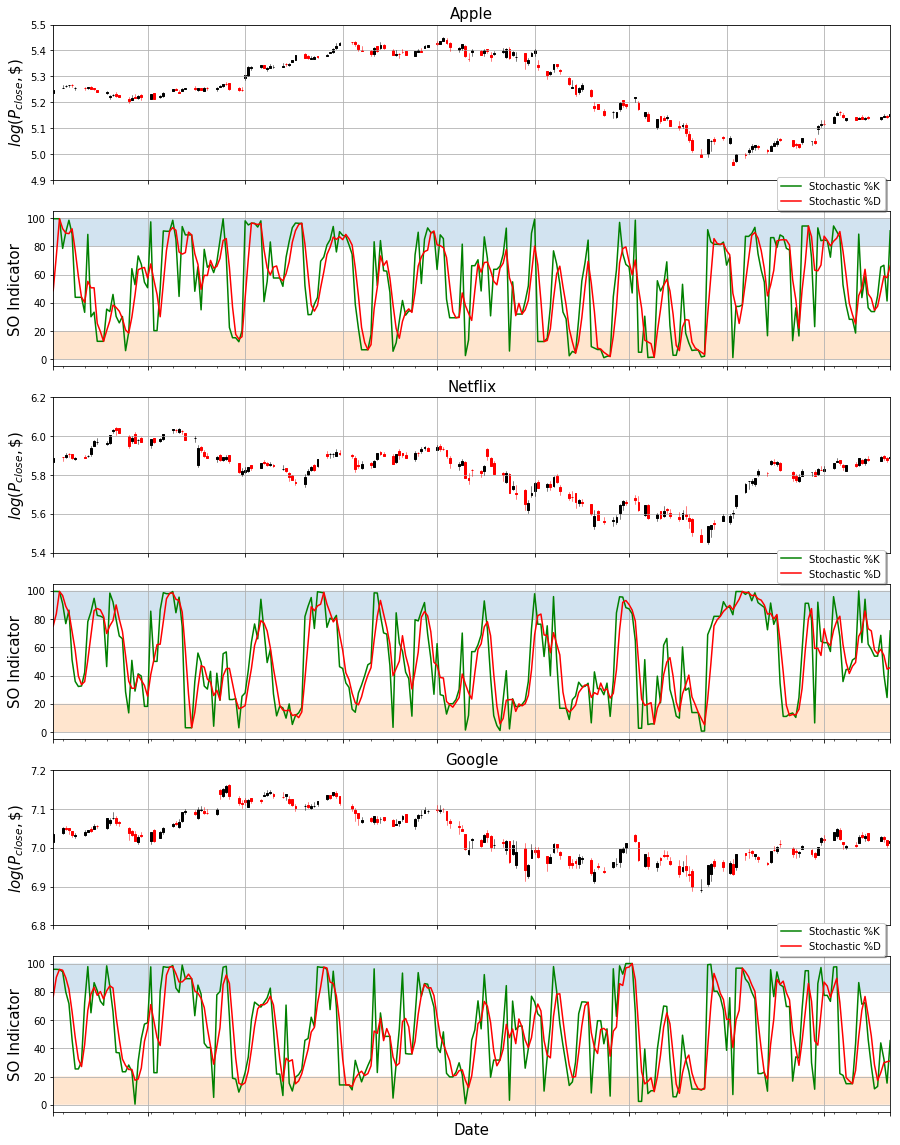

In [11]:
start_date = '2018-06-01'
fig, axs = plt.subplots(6,1, figsize=(15, 20))
for i in range(3):
    stock = pd.read_csv(stock_names[i]+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1],infer_datetime_format=True)
    stock = np.log(stock)
    candlestick_ohlc(axs[2*i], zip(mdates.date2num(stock.index.to_pydatetime()),
                             stock['open'], stock['high'],
                             stock['low'], stock['close']),
                     width=0.6)

    axs[2*i].xaxis_date()
    axs[2*i].set_xlim([start_date,'2019-02-22']) 
    axs[2*i].grid()
    axs[2*i].set_xticklabels('')
    axs[2*i].set_xlabel('')
    axs[2*i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].set_ylim([4.9,5.5])
    axs[2].set_ylim([5.4,6.2])
    axs[4].set_ylim([6.8,7.2]) 
    
    K.loc[start_date:,stock_names[i]].plot(ax = axs[2*i+1], color = 'green',label  = 'Stochastic %K')
    D.loc[start_date:,stock_names[i]].plot(ax = axs[2*i+1], color='red',label  = 'Stochastic %D') 
    axs[2*i+1].set_xlabel('')  
    axs[2*i+1].set_xticklabels('')
    axs[2*i+1].set_ylabel(r'SO Indicator', size = '15')
    axs[2*i+1].legend(loc='upper right', bbox_to_anchor=(1.0, 1.25),fancybox=True, shadow=True)
    axs[2*i].set_title(stock_names[i], size = '15')
    axs[2*i+1].set_xlim([start_date,'2019-02-22'])    
    axs[2*i+1].grid()
    axs[2*i+1].fill_between(df_log.index, 80, 100, alpha = 0.2)
    axs[2*i+1].fill_between(df_log.index, 0, 20, alpha = 0.2)
    
axs[5].set_xlabel('Date',size = '15')    
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')    
plt.subplots_adjust(wspace = 0.04, hspace = 0.2)
plt.show()

# Reltive Strength Index

In [12]:
def SMMA(df,window):
    return df.ewm(ignore_na=False, alpha=1.0 / window,min_periods=0, adjust=True).mean()
def RSIndex(df,ndays=14):
    d = df.diff()
    # "up" period when the stock price on following day is higher
    # "down" period when the stock price on following day is lower
    up,down = 0.5*(d+d.abs()), 0.5*(-d+d.abs())
    # RS  relative strength factor
    RS = SMMA(up,ndays)/SMMA(down,ndays)
    rsi = 100-100/(1+RS)
    return rsi

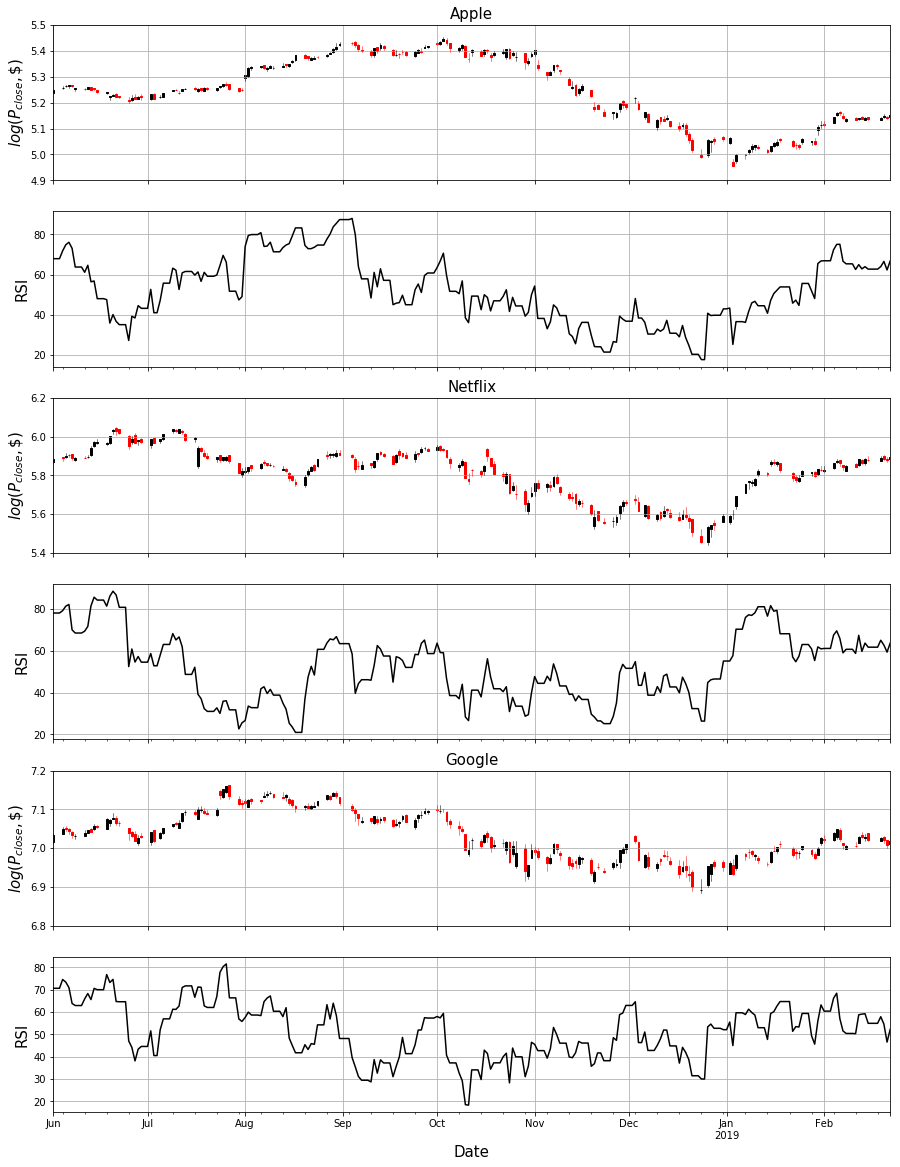

In [13]:
# Compute the RSI Index values
RSI = RSIndex(df_log)
############# PLOTTING #####################
start_date = '2018-06-01'
fig, axs = plt.subplots(6,1, figsize=(15, 20))
for i in range(3):
    # Candlestick Plot
    stock = pd.read_csv(stock_names[i]+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1],infer_datetime_format=True)
    stock = np.log(stock)
    candlestick_ohlc(axs[2*i], zip(mdates.date2num(stock.index.to_pydatetime()),
                             stock['open'], stock['high'],
                             stock['low'],stock['close']),
                     width=0.6)

    axs[2*i].xaxis_date()
    axs[2*i].set_xlim([start_date,'2019-02-22']) 
    axs[2*i].grid()
    axs[2*i].set_xticklabels('')
    axs[2*i].set_xlabel('')
    axs[2*i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].set_ylim([4.9,5.5])
    axs[2].set_ylim([5.4,6.2])
    axs[4].set_ylim([6.8,7.2]) 
    # Plotting the RSI Index
    RSI.loc[start_date:,stock_names[i]].plot(ax = axs[2*i+1], color = 'black') 
    
    #y-axis label
    axs[2*i+1].set_ylabel(r'RSI', size = '15')
    axs[2*i].set_title(stock_names[i], size = '15')
    # X-axis limit from June 2018 to Feb 2019
    axs[2*i+1].set_xlim([start_date,'2019-02-22'])   
    # Draw Grid
    axs[2*i+1].grid()
    # Supress the x-axis and xtick labels except for the last subplot
    if i != 2:
        axs[2*i+1].set_xticklabels('')
        axs[2*i+1].set_xlabel('')
    else:
        axs[2*i+1].set_xlabel('Date',size = '15')
    
# Adjust the spcing between the subplots       
plt.subplots_adjust(wspace = 0.04, hspace = 0.2)
plt.show()

# Commodity Channel Index

In [14]:
def CCIndex(data,ndays=14):
    data_SMA = data.rolling(min_periods=1, window=ndays, center=False).mean()
    data_SMA_MD = data_SMA.rolling(min_periods=1, center=False, window=ndays).apply(lambda x: np.fabs(x - x.mean()).mean())
    cci = (data-data_SMA)/(0.015*data_SMA_MD)
    return cci

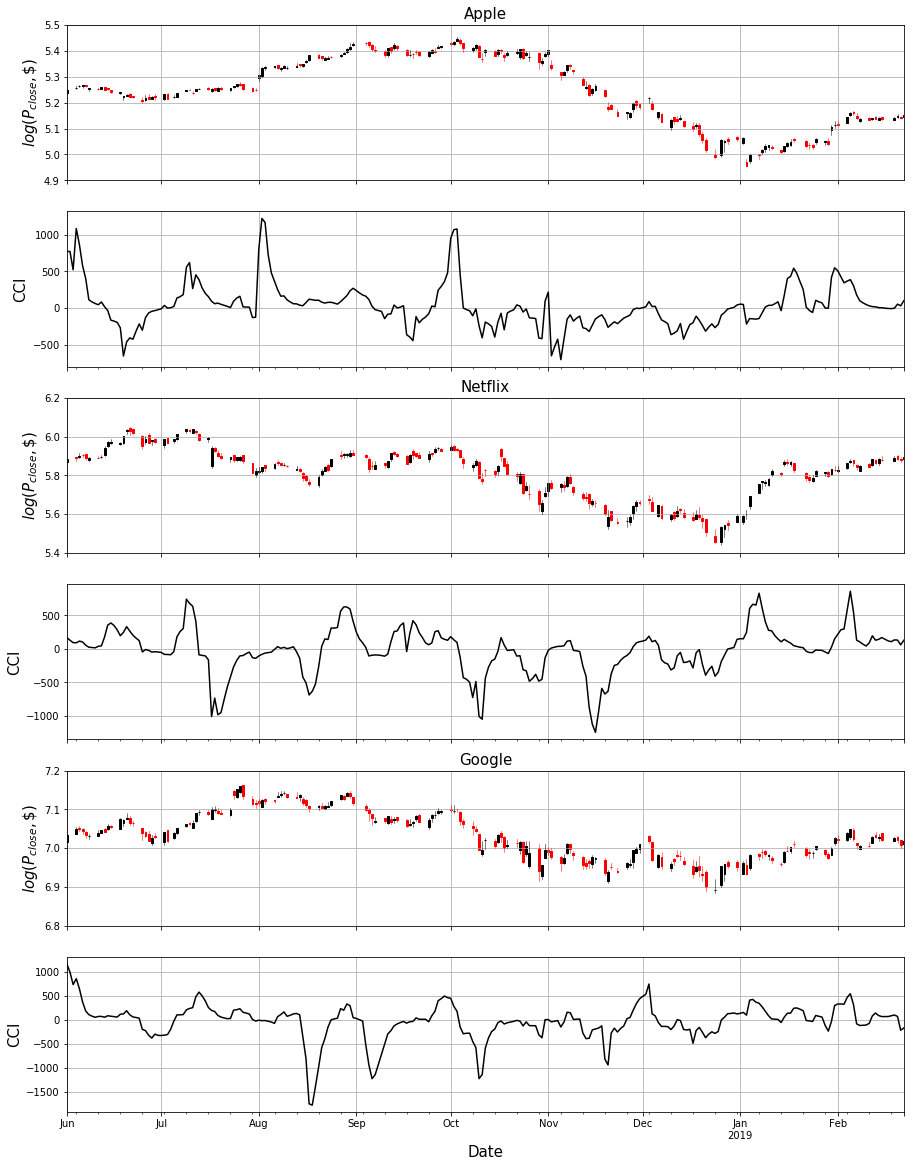

In [15]:
# Preprocess data for CCI Input
cci_input = (df_log+df_high_log+df_low_log)/3
# Call the CCI function
CCI = CCIndex(cci_input)
############# PLOTTING #####################
start_date = '2018-06-01'
fig, axs = plt.subplots(6,1, figsize=(15, 20))
for i in range(3):
    # CandleStick Plots
    stock = pd.read_csv(stock_names[i]+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1],infer_datetime_format=True)
    stock = np.log(stock)
    candlestick_ohlc(axs[2*i], zip(mdates.date2num(stock.index.to_pydatetime()),
                             stock['open'], stock['high'],
                             stock['low'], stock['close']),
                     width=0.6)

    axs[2*i].xaxis_date()
    axs[2*i].set_xlim([start_date,'2019-02-22']) 
    axs[2*i].grid()
    axs[2*i].set_xticklabels('')
    axs[2*i].set_xlabel('')
    axs[2*i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].set_ylim([4.9,5.5])
    axs[2].set_ylim([5.4,6.2])
    axs[4].set_ylim([6.8,7.2]) 
    
    # Plot the Commodity Index Under the respective stock candle stick plots
    CCI.loc[start_date:,stock_names[i]].plot(ax = axs[2*i+1], color = 'black')    
    #y-axis label
    axs[2*i+1].set_ylabel(r'CCI', size = '15')
    axs[2*i].set_title(stock_names[i], size = '15')
    # X-axis limit from June 2018 to Feb 2019
    axs[2*i+1].set_xlim([start_date,'2019-02-22'])   
    # Draw Grid
    axs[2*i+1].grid()
    # Supress the x-axis and xtick labels except for the last subplot
    if i != 2:
        axs[2*i+1].set_xticklabels('')
        axs[2*i+1].set_xlabel('')
    else:
        axs[2*i+1].set_xlabel('Date',size = '15')
  
# Adjust the spcing between the subplots
plt.subplots_adjust(wspace = 0.04, hspace = 0.2)
plt.show()

# RANDOM FOREST MODEL

In [16]:
n_est=[500,2000,300]
max_fea=[3,3,3]
max_dep = [110,100,90]
min_s_split = [3,11,4]
min_s_leaf = [4,3,1]
# Empty Dataframe to store RandomForest predictions
df_rf = pd.DataFrame()
rf_mape = []
importance_dict = {}

for i in range(3):
    df = pd.DataFrame()
    df = pd.concat([df_log.iloc[:,i], 
                    SMA5.iloc[:,i], SMA10.iloc[:,i], 
                    EMA5.iloc[:,i], EMA10.iloc[:,i],
                    macd_line.iloc[:,i],macd_signal.iloc[:,i],
                    K.iloc[:,i],D.iloc[:,i],
                    RSI.iloc[:,i],CCI.iloc[:,i]],axis = 1)
    # Label the columns
    column_labels = ['Close','SMA5','SMA10','EMA5','EMA10','macd_line','macd_signal','%K','%D','RSI','CCI']
    df.columns = column_labels
    # Remove NA rows
    df = df.dropna()
    # Split the data into training and test setp
    train, test = df[:'2019-01-31'],df['2019-02-01':]
    # Training and test features and variables
    trainX, trainY, testX, testY = train.iloc[:,1:],train.iloc[:,0],test.iloc[:,1:],test.iloc[:,0]
    # Define the RandomForest Model with arguments
    Model = RandomForestRegressor(n_estimators=n_est[i],max_features=max_fea[i],max_depth = max_dep[i],
                                     min_samples_split = min_s_split[i],min_samples_leaf = min_s_leaf[i])
    # Fit the model
    RF_model=Model.fit(trainX,trainY)
    # Compute the fitted and predicted values
    train_pred, test_pred = RF_model.predict(trainX),RF_model.predict(testX)
    # Random Forest MAPE
    rf_mape.append(MAPE(testY,test_pred))
    
    # Store the results in dataframe
    df_rf[stock_names[i]] = df.iloc[:,i]
    df_rf[stock_names[i]+'_predict'] = np.concatenate([train_pred,test_pred])
    ## Plotting the variable Importance
    # storing it in dictionary just to practice ssomething different
    importance_dict[stock_names[i]] = list(RF_model.feature_importances_)


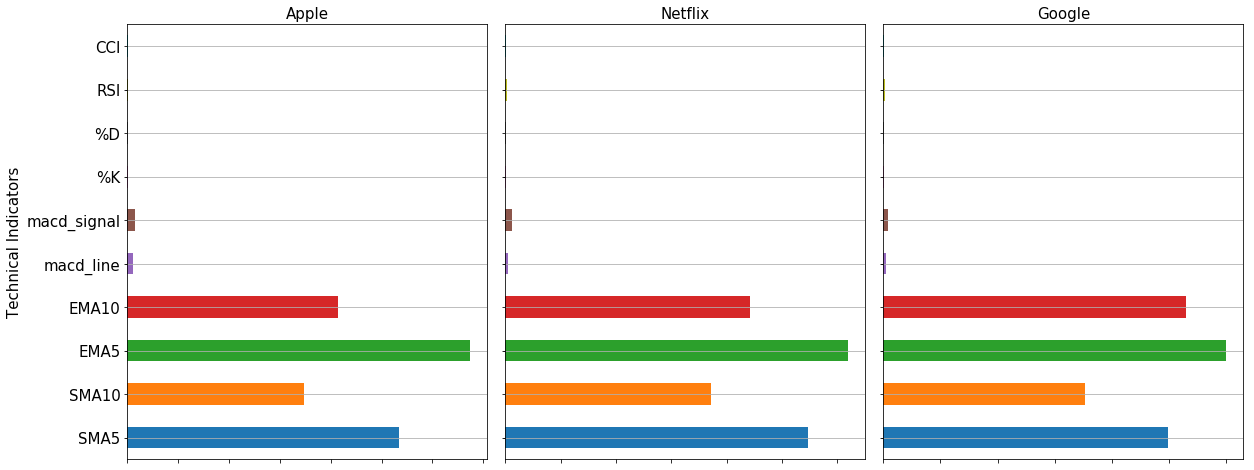

In [17]:
# Variable Importance Plots
impdf = pd.DataFrame(importance_dict, index = column_labels[1:])
fig, axs = plt.subplots(1,3, figsize=(20, 8),sharey = True)
for i in range(3):
    impdf.iloc[:,i].plot.barh(ax = axs[i])
    axs[i].set_ylabel(r'Technical Indicators', size = '15')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels(impdf.index,size = '15')
    axs[i].set_title(stock_names[i], size = '15')
    axs[i].yaxis.grid()
plt.subplots_adjust(wspace = 0.05)
plt.show()

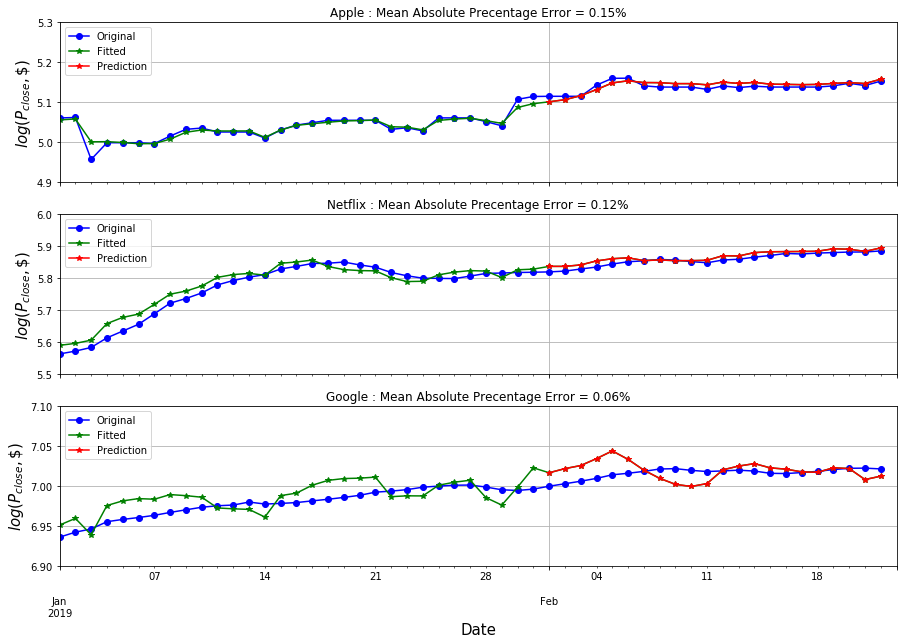

In [18]:
# Random Forest Model observed versus predicted value
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):
    df_rf.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], color = 'blue', marker = 'o')
    df_rf.loc['2019-01-01':,stock_names[i]+'_predict'].plot(ax = axs[i], color = 'green', marker = '*')
    df_rf.loc['2019-02-01':,stock_names[i]+'_predict'].plot(ax = axs[i], color='red', marker = '*')

    axs[i].set_title('{} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],np.around(rf_mape[i],2)))
    axs[i].grid()
    axs[2].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].legend(['Original','Fitted','Prediction'],loc = 'upper left')
    axs[0].set_ylim([4.9,5.3])
    axs[1].set_ylim([5.5,6.0])
    axs[2].set_ylim([6.9,7.1])
    axs[i].set_xlim(['2019-01-01','2019-02-23'])
plt.show()

# BOOSTING

In [22]:
gam = 0
n_est=1000
max_dep = 3
b_score =0.1
cols_bytree = 0.1
l_rate = 0.06
ssample = [0.5,1.0,0.8]
# Empty Dataframe to store RandomForest predictions
df_xgb = pd.DataFrame()
xgb_mape = []
importance_dict = {}

for i in range(3):
    df = pd.DataFrame()
    df = pd.concat([df_log.iloc[:,i], 
                    SMA5.iloc[:,i], SMA10.iloc[:,i], 
                    EMA5.iloc[:,i], EMA10.iloc[:,i],
                    macd_line.iloc[:,i],macd_signal.iloc[:,i],
                    K.iloc[:,i],D.iloc[:,i],
                    RSI.iloc[:,i],CCI.iloc[:,i]],axis = 1)
    # Label the columns
    column_labels = ['Close','SMA5','SMA10','EMA5','EMA10','macd_line','macd_signal','%K','%D','RSI','CCI']
    df.columns = column_labels
    # Remove NA rows
    df = df.dropna()
    # Split the data into training and test setp
    train, test = df[:'2019-01-31'],df['2019-02-01':]
    # Training and test features and variables
    trainX, trainY, testX, testY = train.iloc[:,1:],train.iloc[:,0],test.iloc[:,1:],test.iloc[:,0]
    # Define the RandomForest Model with arguments
    ModelX = xgb.XGBRegressor(gamma=gam,n_estimators=n_est,
                             max_depth = max_dep,base_score=b_score,
                             colsample_bytree=cols_bytree,learning_rate=l_rate,
                             subsample = ssample[i])

    # Fit the model
    XGB_model=ModelX.fit(trainX,trainY)
    # Compute the fitted and predicted values
    train_pred, test_pred = XGB_model.predict(trainX),RF_model.predict(testX)
    # Random Forest MAPE
    xgb_mape.append(MAPE(testY,test_pred))
    
    # Store the results in dataframe
    df_xgb[stock_names[i]] = df.iloc[:,i]
    df_xgb[stock_names[i]+'_predict'] = np.concatenate([train_pred,test_pred])
    
    ## Plotting the variable Importance
    # storing it in dictionary just to practice ssomething different
    importance_dict[stock_names[i]] = list(XGB_model.feature_importances_)

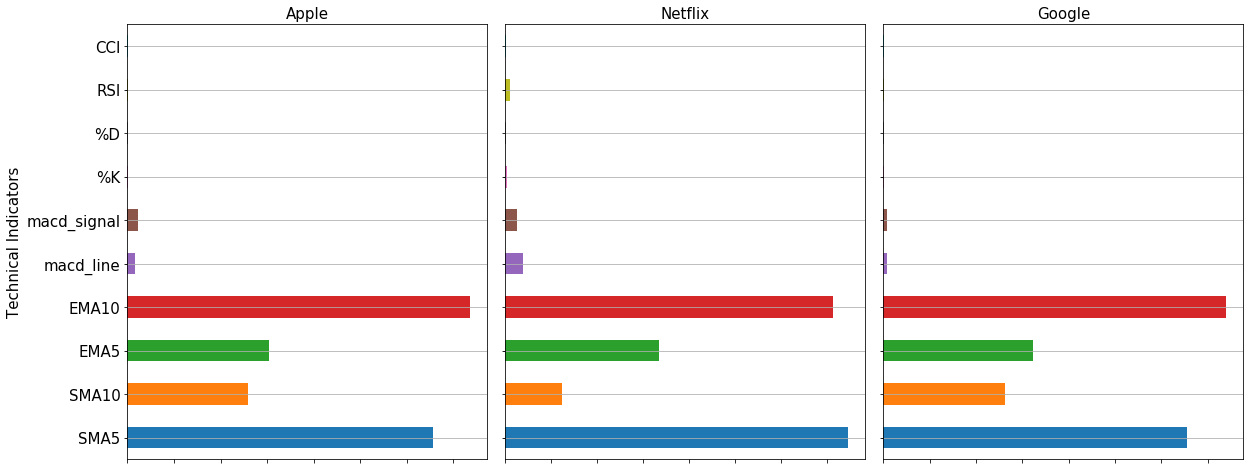

In [23]:
# Variable Importance Plots
impdf = pd.DataFrame(importance_dict, index = column_labels[1:])
fig, axs = plt.subplots(1,3, figsize=(20, 8),sharey = True)
for i in range(3):
    impdf.iloc[:,i].plot.barh(ax = axs[i])
    axs[i].set_ylabel(r'Technical Indicators', size = '15')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels(impdf.index,size = '15')
    axs[i].set_title(stock_names[i], size = '15')
    axs[i].yaxis.grid()
plt.subplots_adjust(wspace = 0.05)
plt.show()

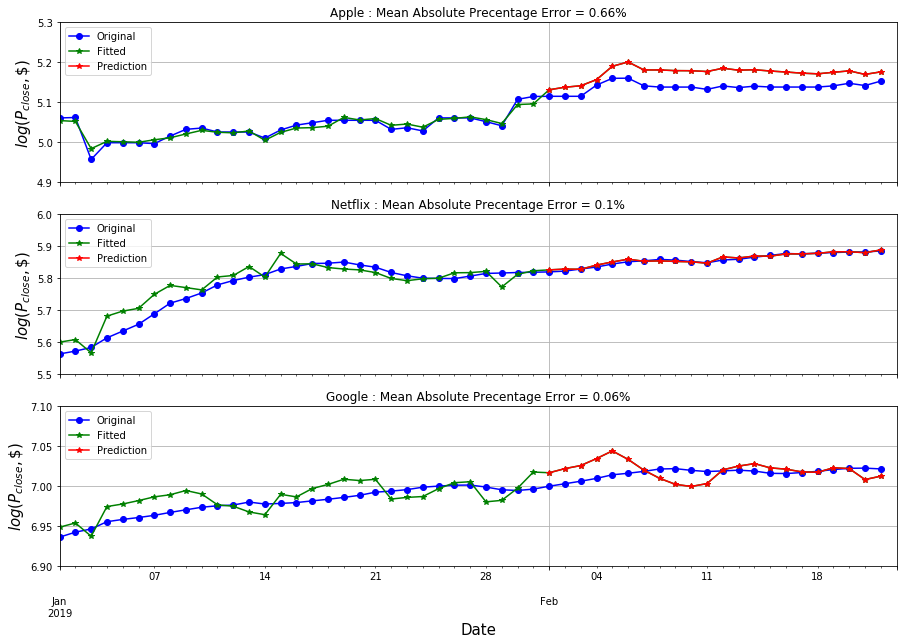

In [24]:
# Random Forest Model observed versus predicted value
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):
    df_xgb.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], color = 'blue', marker = 'o')
    df_xgb.loc['2019-01-01':,stock_names[i]+'_predict'].plot(ax = axs[i], color = 'green', marker = '*')
    df_xgb.loc['2019-02-01':,stock_names[i]+'_predict'].plot(ax = axs[i], color='red', marker = '*')

    axs[i].set_title('{} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],np.around(xgb_mape[i],2)))
    axs[i].grid()
    axs[2].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].legend(['Original','Fitted','Prediction'],loc = 'upper left')
    axs[0].set_ylim([4.9,5.3])
    axs[1].set_ylim([5.5,6.0])
    axs[2].set_ylim([6.9,7.1])
    axs[i].set_xlim(['2019-01-01','2019-02-23'])
plt.show()